# Observe Refactor Testing
Refactoring how data products are produced to account extra spectral dimension in spectrometer instruments. This notebook is for testing that new functionality.

In [1]:
import os
import copy
import sys
import subprocess
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import seaborn
import astropy.units as u
import h5py
import sunpy.map

import synthesizAR
from synthesizAR.atomic import EquilibriumEmissionModel
from synthesizAR.model_ext import EbtelInterface,PowerLawScaledWaitingTimes
from synthesizAR.instruments import InstrumentHinodeEIS,InstrumentSDOAIA


%matplotlib inline

/opt/anaconda3/envs/synthesizar_refactor/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/opt/anaconda3/envs/synthesizar_refactor/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


 using cli
 using CLI for selections
 reading chiantirc file


In [2]:
ar_root = '/data/datadrive2/ar_viz/instr_refactor/'

## Field

In [ ]:
crop = (u.Quantity([-400,-140]*u.arcsec),u.Quantity([320,540]*u.arcsec))
resample = u.Quantity([100,100]*u.pixel)
field = synthesizAR.Skeleton('/home/wtb2/sunpy/data/hmi_m_45s_2010_06_19_03_06_00_tai_magnetogram.fits',
                             crop=crop,resample=resample)
zshape=50
zrange=u.Quantity([0.,150.]*u.arcsec)
field.extrapolate_field(zshape,zrange)

In [ ]:
field.extract_streamlines(700,loop_length_range=[1e+9,1e+11]*u.cm)

In [ ]:
field.make_loops()

## Model

In [ ]:
heating_options = {
    'duration':200.0,
    'duration_rise':100.0,
    'duration_decay':100.0,
    'average_waiting_time':2500.0,
    'stress_level':0.3,
    'alpha':-2.5,
    'delta_power_law_bounds':100,
    'waiting_time_scaling':1.0,
}
heating_model = PowerLawScaledWaitingTimes(heating_options)

In [ ]:
ih = synthesizAR.util.InputHandler(os.path.join(os.environ['RESEARCH_DIR'],'ebtelPlusPlus/config/ebtel.example.cfg.xml'))
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['use_adaptive_solver'] = True
base_config['tau'] = 1.0
base_config['adaptive_solver_error'] = 1e-12
base_config['adaptive_solver_safety'] = 0.01
base_config['total_time'] = 5000.0
ebtel_plug = EbtelInterface(base_config,heating_model)
field.configure_loop_simulations(ebtel_plug,
                                 parent_config_dir=os.path.join(ar_root,'hydro_config'),
                                 parent_results_dir=os.path.join(ar_root,'hydro_results'))

In [ ]:
for loop in field.loops:
    subprocess.call([os.path.join(os.environ['RESEARCH_DIR'],'ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [ ]:
field.load_loop_simulations(ebtel_plug,savefile=os.path.join(ar_root,'loop_parameters.h5'))

In [ ]:
field.save(savedir=os.path.join(ar_root,'checkpoint'))

## Emission
Steal the emissivity from a previous model so we don't have to run this part again.

In [3]:
emiss_model = EquilibriumEmissionModel.restore('/data/datadrive2/ar_viz/synthesizar_v01demo/checkpoint_emiss_model/')

INFO:EquilibriumEmissionModel:Using CHIANTI HDF5 database in /data/datadrive2/ar_viz/synthesizar_v01demo/chianti_db.h5
INFO:EquilibriumEmissionModel:Creating ion si_7
INFO:EquilibriumEmissionModel:Creating ion fe_10
INFO:EquilibriumEmissionModel:Creating ion fe_11
INFO:EquilibriumEmissionModel:Creating ion fe_12
INFO:EquilibriumEmissionModel:Creating ion fe_13
INFO:EquilibriumEmissionModel:Creating ion fe_15
INFO:EquilibriumEmissionModel:Creating ion s_13
INFO:EquilibriumEmissionModel:Creating ion fe_16
INFO:EquilibriumEmissionModel:Creating ion ca_17
INFO:EquilibriumEmissionModel:Restoring emission model from /data/datadrive2/ar_viz/synthesizar_v01demo/checkpoint_emiss_model/


Calculate the emissivity for each loop.

In [ ]:
field.calculate_emission(emiss_model,savefile=os.path.join(ar_root,'loop_emiss.h5'))

Save the field again.

In [ ]:
field.save(savedir=os.path.join(ar_root,'checkpoint'))

Restore here if needed.

In [4]:
field = synthesizAR.Skeleton.restore(os.path.join(ar_root,'checkpoint'))

yt : [INFO     ] 2017-01-16 14:16:12,723 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-01-16 14:16:12,724 Parameters: domain_dimensions         = [96 96 46]
yt : [INFO     ] 2017-01-16 14:16:12,725 Parameters: domain_left_edge          = [ -2.89511786e+10   2.37893407e+10   4.40182588e+08]
yt : [INFO     ] 2017-01-16 14:16:12,726 Parameters: domain_right_edge         = [ -1.06601257e+10   3.93100982e+10   1.05643821e+10]
yt : [INFO     ] 2017-01-16 14:16:12,727 Parameters: cosmological_simulation   = 0.0


## Detect
Now we'll try out our new detect methods. First declare the instruments.

In [5]:
eis = InstrumentHinodeEIS('/home/wtb2/Documents/Forward_Model/instruments/Hinode_EIS/',[0,4900]*u.s)

In [6]:
aia = InstrumentSDOAIA([0,4900]*u.s,response_function_file='aia_tresponse_raw.dat')

In [7]:
new_channels = []
for channel in eis.channels:
    for wvl in emiss_model.wavelengths:
        if channel['response']['x'][0] <= wvl <= channel['response']['x'][-1]:
            new_channels.append(channel)
            break
eis.channels = new_channels

Now create the observer object, adding all of the instruments.

In [8]:
observer = synthesizAR.Observer(field,[eis,aia],ds=field._convert_angle_to_length(0.3*u.arcsec))
#observer.logger.setLevel(logging.DEBUG)

/opt/anaconda3/envs/synthesizar_refactor/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/opt/anaconda3/envs/synthesizar_refactor/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


Next, build all of the needed files for storing the intermediate detector results.

In [9]:
observer.build_detector_files(ar_root)

INFO:InstrumentHinodeEIS:Creating instrument file /data/datadrive2/ar_viz/instr_refactor/Hinode_EIS_counts.h5
INFO:InstrumentSDOAIA:Creating instrument file /data/datadrive2/ar_viz/instr_refactor/SDO_AIA_counts.h5


Now, flatten all of the emission as a function of $s,t$ for each loop to a single data structure.

In [ ]:
observer.flatten_detector_counts()

In [23]:
observer.logger.setLevel(logging.INFO)
observer.bin_detector_counts(ar_root)

INFO:Observer:Building data products for Hinode_EIS
INFO:Observer:Building data products for SDO_AIA


## Visualization

As a test, take a look at the LOS velocity as a map.

In [ ]:
sdo_map = sunpy.map.Map('/data/datadrive2/ar_viz/instr_refactor/SDO_AIA/94/map_t000000.fits')

In [ ]:
sdo_map.peek()

In [ ]:
aia_plot = sdo_map.plot(
    norm=matplotlib.colors.SymLogNorm(1e-2,vmin=1,vmax=1000),
)
plt.colorbar(aia_plot)

/opt/anaconda3/envs/synthesizar_refactor/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


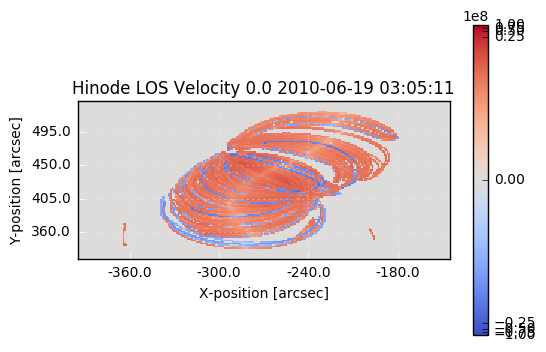

In [11]:
vel_map = observer.make_los_velocity_map(eis.observing_time[400],eis)
vel_map.peek()

/opt/anaconda3/envs/synthesizar_refactor/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


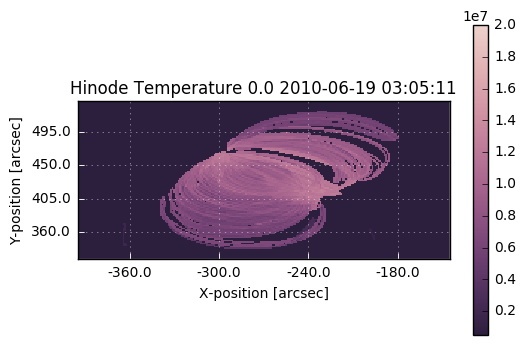

In [22]:
temp_map = observer.make_temperature_map(eis.observing_time[20],eis)
#temp_map.plot_settings.update({'norm':matplotlib.colors.SymLogNorm(1e4,})
temp_map.peek(vmin=5e5,vmax=2e7)